##### Imports

In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', None)  # Mostra o texto completo
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import requests
import zipfile
import numpy as np
import string
import sys

import emoji
import unidecode
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag, word_tokenize
from nltk.tokenize import word_tokenize
from tqdm import tqdm


# Caminho da pasta "root"
base_dir = Path(os.getcwd()).resolve()  # Ajuste se necessário, podes utilizar .parent para subir um nível
data_dir = base_dir / "Data"  # Diretório onde os dados serão armazenados
base_dir

WindowsPath('C:/Users/diogo/Desktop/Filologia_Digital-Modulo_V/Session4')

In [27]:
!pip install xgboost

Looking in indexes: https://download.pytorch.org/whl/nightly/cu129
  Using cached https://download.pytorch.org/whl/nightly/sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/nightly/fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ---------------------------------------- 0.0/3.6 GB ? eta -:--:--
     ---------------------------------------- 0.0/3.6 GB 29.4 MB/s eta 0:02:02
     ---------------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##### Funções importantes

In [11]:
src_dir = base_dir / "src"
sys.path.append(str(src_dir))

# Importar os módulos
try:
    from common_functions import plot_confusion_matrix, plot_confusion_matrix_glove, print_classification_report, print_classification_report_glove, clean_text
except ImportError:
    print("Erro: Não foi possível importar algum módulo. Verifique se o caminho está correto.")

In [12]:
from nltk.corpus import stopwords

# Stopwords com preservação de negações
negation_words = {
    'no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere',
    "n't", "cannot", "can't", "dont", "don't", "doesn't", "isn't", "wasn't",
    "aren't", "hasn't", "haven't", "hadn't", "won't", "wouldn't", "shouldn't",
    "couldn't", "mightn't", "mustn't", "shan't", "without", "barely", 
    "hardly", "scarcely", "rarely", "seldom", "nor", "ain't"
}
stop_words = set(stopwords.words('english')) - negation_words

def clean_text_ultimate(text, apply_lowercase=True, remove_emojis=True, do_stemming=True, use_pos=True,
               remove_urls=True, remove_hashtags=True, remove_numbers=True,
               handle_negation=True):
    if not isinstance(text, str):  
        return ""
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    if apply_lowercase:
        text = text.lower()

    # Remove URLs, hashtags, números e emojis
    if remove_urls:
        text = re.sub(r"http\S+|www.\S+|\burl\b", "", text)
    if remove_hashtags:
        text = re.sub(r"#", "", text)
    if remove_numbers:
        text = re.sub(r"\d+", "", text)
    if remove_emojis:
        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'(:\)|:\(|:D|:P|;-?\)|:-?\(|:O|:\||:3|:\'\(|:\/|:s|xD)', '', text, flags=re.IGNORECASE)
    
    text = re.sub(r'^(rt[:\s]*(user\s*)+)', '', text, flags=re.IGNORECASE).strip()
    text = unidecode.unidecode(text)

    tokens = tokenizer.tokenize(text)

    # Negation handling
    if handle_negation:
        negation_scope = False
        punctuations = {'.', ',', ';', ':', '!', '?'}
        processed_tokens = []
        for token in tokens:
            if token in negation_words: # dicionario lá de cima
                negation_scope = True
                processed_tokens.append(token)
                continue
            if token in punctuations:
                negation_scope = False
            if negation_scope:
                token = f"NEG_{token}"
            processed_tokens.append(token)
        tokens = processed_tokens

    # POS tagging ou stemming
    filtered = []
    if use_pos:
        tagged = pos_tag(tokens)
        for word, tag in tagged:
            if word not in stop_words:
                wn_tag = get_wordnet_pos(tag)
                word = lemmatizer.lemmatize(word, pos=wn_tag)
                filtered.append(word)
    else:
        if do_stemming:
            stemmer = SnowballStemmer("english")
            filtered = [stemmer.stem(w) for w in tokens if w not in stop_words]
        else:
            filtered = [w for w in tokens if w not in stop_words]

    filtered = [word for word in filtered if len(word) > 1]
    return " ".join(filtered)

best_params = {
    "apply_lowercase": False,
    "remove_emojis": True,
    "do_stemming": False,
    "use_pos": False,
    "remove_urls": False,
    "remove_hashtags": True,
    "remove_numbers": True,
    "handle_negation": True
}

## 0. Leitura dos dados

In [13]:
DataSetsChosen = "Tweets_EN_sentiment"
Dataset_train, Dataset_test = DataSetsChosen + "_train.csv", DataSetsChosen + "_test.csv"
df_train, df_test = pd.read_csv(data_dir / Dataset_train), pd.read_csv(data_dir / Dataset_test)

df_test

,tweet,text,class
0,1229614408,G Night world,pos
1,1229158792,Morning all just got home from taking my daughter to the doc's. I want a maid!,pos
2,1228398639,"thanks for the follow - how are you connected with B&GC? I've been our Board for 6 years, Chair for the past 4",pos
3,1229411644,re: Home Depot...hey! maybe we'll see you there... : ),pos
4,1230107823,tak jsem poprve v zivote napsala zpravicku na USER URL,pos
...,...,...,...
9980,1228266179,"Productive day today FTW! Bought/wrapped gifts, handwashed & detailed my car inside/out, cooked a turkey, etc. I'll be a great housewife.",pos
9981,1229022249,Thanks,pos
9982,1229969913,Nice! Thanks for the info,pos
9983,1230580122,"daaaaamn... i shoulda came down there, but you cant buy records with lint",neg


> ### 0.1. Pré-processamento simples

In [14]:
best_params = {
    "apply_lowercase": False,
    "remove_emojis": True,
    "do_stemming": False,
    "use_pos": False,
    "remove_urls": False,
    "remove_hashtags": True,
    "remove_numbers": True,
    "handle_negation": True
}

# Garantir que todos os textos são strings válidas
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

# Aplicar a função com os melhores parâmetros ao DataFrame
df_train['clean_text'] = df_train["text"].apply(lambda x: clean_text_ultimate(x, **best_params))
df_test['clean_text'] = df_test["text"].apply(lambda x: clean_text_ultimate(x, **best_params))

In [15]:
df_train

,tweet,text,class,clean_text
0,1229448571,"some count sheep, you count cats",pos,count sheep count cats
1,1230261573,We haven't been to Turning Stone in ages! Have a great time,pos,haven't NEG_been NEG_to NEG_turning NEG_stone NEG_in NEG_ages great time
2,1228861415,What up,pos,
3,1228489365,I'm good,pos,good
4,1229800235,"I know, wonder if USER is going to buy an apartment after he's bought the jets",pos,know wonder user going buy apartment bought jets
...,...,...,...,...
39931,1230130325,"LOL- F, please",pos,lol please
39932,1229250927,I wish I could do that too! But it ain't happening,neg,wish could ain't NEG_happening
39933,1228710021,I &lt;3 my boyfriend's family.,pos,boyfriend's family
39934,1228100681,404,neg,


In [16]:
# Variáveis target
y_train = df_train['class']
y_test = df_test['class']

> ### 0.2. Pré-processamento do TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigramas e bigramas
    min_df=5,  # Ignorar palavras que aparecem em menos de 5 documentos
    max_df=0.85,  # Ignorar palavras que aparecem em mais de 85% dos documentos
    # norm='l2'  # Normalização L2
)

# Ajustar aos dados de treino
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
X_test_tfidf = tfidf.transform(df_test['clean_text'])

## 1. ``LogisticRegression``

### 1.1. Modelo com ``TfidfVectorizer`` + ``LogisticRegression``

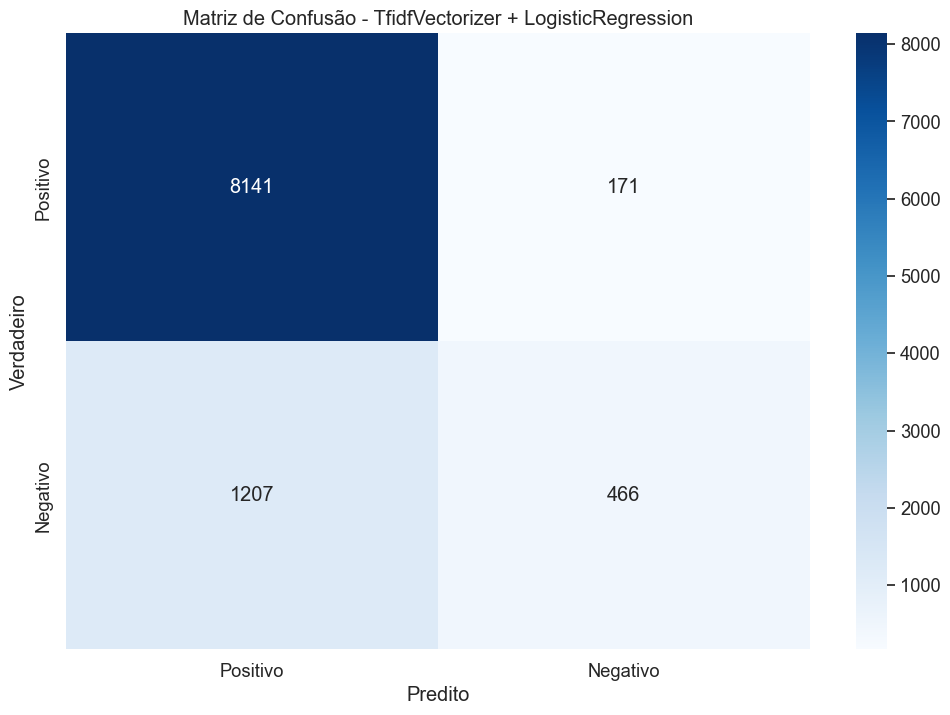


=== Relatório de Desempenho: TfidfVectorizer + LogisticRegression ===
Accuracy : 0.8620
Precisão : 0.8709
Recall   : 0.9794
F1-score : 0.9220

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.73      0.28      0.40      1673
         pos       0.87      0.98      0.92      8312

    accuracy                           0.86      9985
   macro avg       0.80      0.63      0.66      9985
weighted avg       0.85      0.86      0.84      9985



In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

plot_confusion_matrix(y_test, y_pred, model_name="TfidfVectorizer + LogisticRegression")
print_classification_report(y_test, y_pred, model_name="TfidfVectorizer + LogisticRegression")

In [ ]:
# Frase de exemplo
nova_frase = "I hate this product. It's the worst I've ever used."

# 1. Aplicar a mesma função de limpeza usada no treino
frase_limpa = clean_text_ultimate(nova_frase, **best_params)

# 2. Vetorizar com o mesmo TF-IDF treinado (atenção: .transform, não .fit_transform!)
frase_vetorizada = tfidf.transform([frase_limpa])  # Coloca-se dentro de lista!

# 3. Prever a classe
predicao = clf.predict(frase_vetorizada)

# 4. Mostrar o resultado
print("Frase:", nova_frase)
print("Frase limpa:", frase_limpa)
print("Previsão:", predicao[0])

Frase: I hate this product. It's the worst I've ever used.
Frase limpa: hate product worst ever used
Predição: neg


## 2. ``SVM``

In [19]:
kernel = 'linear' # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

### 2.1. Modelo com ``TfidfVectorizer`` + ``SVM``

c:\Users\diogo\Desktop\Filologia_Digital-Modulo_V\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


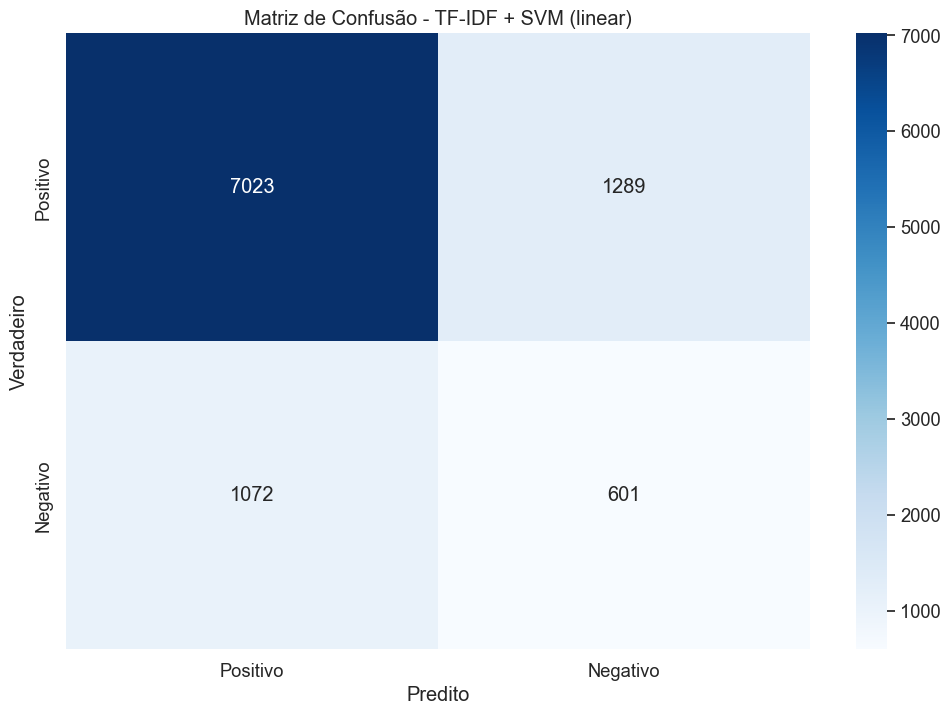


=== Relatório de Desempenho: TF-IDF + SVM (linear) ===
Accuracy : 0.7635
Precisão : 0.8676
Recall   : 0.8449
F1-score : 0.8561

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.32      0.36      0.34      1673
         pos       0.87      0.84      0.86      8312

    accuracy                           0.76      9985
   macro avg       0.59      0.60      0.60      9985
weighted avg       0.78      0.76      0.77      9985



In [20]:
from sklearn.svm import SVC

# Treinar o modelo de SVM com TF-IDF
svm_tfidf = SVC(kernel=kernel, max_iter=1000)
svm_tfidf.fit(X_train_tfidf, y_train)

# Prever e avaliar
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

# Avaliar
plot_confusion_matrix(y_test, y_pred_svm_tfidf, model_name=f"TF-IDF + SVM ({kernel})")
print_classification_report(y_test, y_pred_svm_tfidf, model_name=f"TF-IDF + SVM ({kernel})")

In [ ]:
# Frase de exemplo
nova_frase = "I hate this product. It's the worst I've ever used."

# 1. Aplicar a mesma função de limpeza usada no treino
frase_limpa = clean_text_ultimate(nova_frase, **best_params)

# 2. Vetorizar com o mesmo TF-IDF treinado (atenção: .transform, não .fit_transform!)
frase_vetorizada = tfidf.transform([frase_limpa])  # Coloca-se dentro de lista!

# 3. Prever a classe
predicao = svm_tfidf.predict(frase_vetorizada)

# 4. Mostrar o resultado
print("Frase:", nova_frase)
print("Frase limpa:", frase_limpa)
print("Previsão:", predicao[0])

Frase: I hate this product. It's the worst I've ever used.
Frase limpa: hate product worst ever used
Predição: neg


## 3. ``Random Forest``

### 3.1. Modelo com ``TfidfVectorizer`` + ``Random Forest``

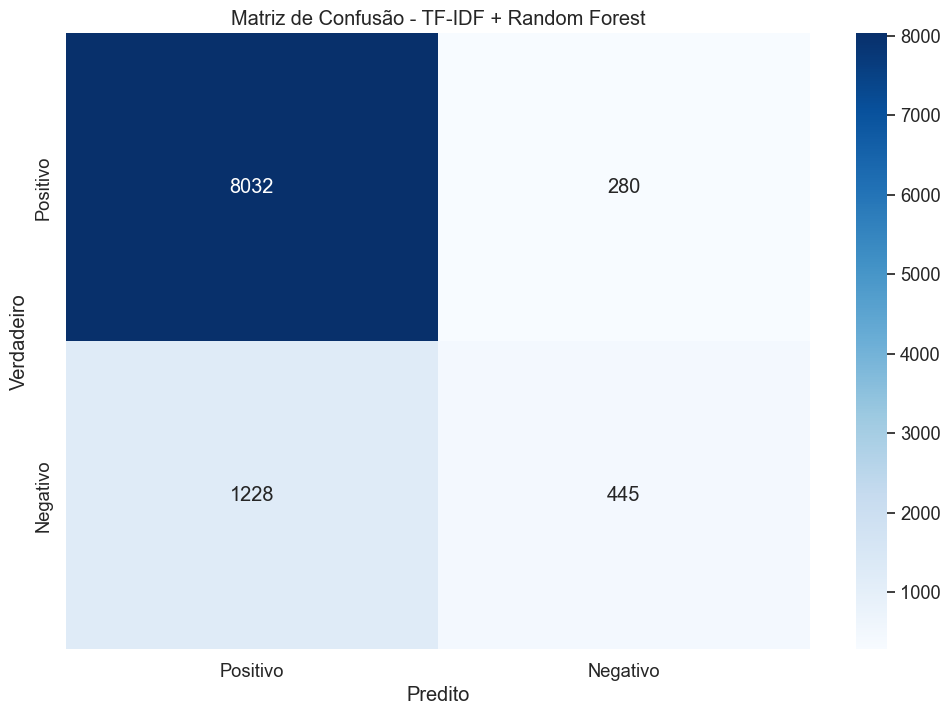


=== Relatório de Desempenho: TF-IDF + Random Forest ===
Accuracy : 0.8490
Precisão : 0.8674
Recall   : 0.9663
F1-score : 0.9142

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.61      0.27      0.37      1673
         pos       0.87      0.97      0.91      8312

    accuracy                           0.85      9985
   macro avg       0.74      0.62      0.64      9985
weighted avg       0.82      0.85      0.82      9985



In [21]:
from sklearn.ensemble import RandomForestClassifier

# Treinar o modelo de Random Forest com TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)

# Prever e avaliar
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)

# Avaliar
plot_confusion_matrix(y_test, y_pred_rf_tfidf, model_name="TF-IDF + Random Forest")
print_classification_report(y_test, y_pred_rf_tfidf, model_name="TF-IDF + Random Forest")

In [ ]:
# Frase de exemplo
nova_frase = "I hate this product. It's the worst I've ever used."

# 1. Aplicar a mesma função de limpeza usada no treino
frase_limpa = clean_text_ultimate(nova_frase, **best_params)

# 2. Vetorizar com o mesmo TF-IDF treinado (atenção: .transform, não .fit_transform!)
frase_vetorizada = tfidf.transform([frase_limpa])  # Coloca-se dentro de lista!

# 3. Prever a classe
predicao = rf_tfidf.predict(frase_vetorizada)

# 4. Mostrar o resultado
print("Frase:", nova_frase)
print("Frase limpa:", frase_limpa)
print("Previsão:", predicao[0])

Frase: I hate this product. It's the worst I've ever used.
Frase limpa: hate product worst ever used
Predição: neg


## 4. ``K-Nearest Neighbors (KNN)``

### 4.1. Modelo com ``TfidfVectorizer`` + ``KNN``

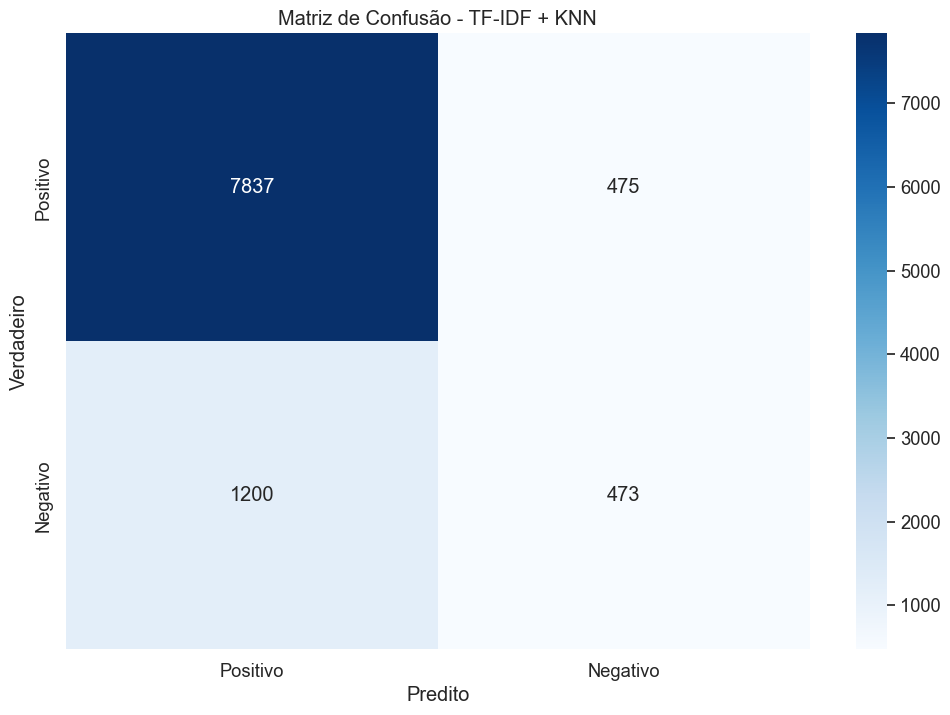


=== Relatório de Desempenho: TF-IDF + KNN ===
Accuracy : 0.8322
Precisão : 0.8672
Recall   : 0.9429
F1-score : 0.9035

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.50      0.28      0.36      1673
         pos       0.87      0.94      0.90      8312

    accuracy                           0.83      9985
   macro avg       0.68      0.61      0.63      9985
weighted avg       0.81      0.83      0.81      9985



In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Treinar o modelo de KNN com TF-IDF
knn_tfidf = KNeighborsClassifier(
    n_neighbors=5,         # Podes ajustar este valor com validação cruzada
    weights='distance',    # Dá mais peso aos vizinhos mais próximos
    metric='cosine',       # Cosine é mais adequado para dados TF-IDF
    n_jobs=-1              # Usa todos os núcleos para acelerar
)
knn_tfidf.fit(X_train_tfidf, y_train)

# Prever e avaliar
y_pred_knn_tfidf = knn_tfidf.predict(X_test_tfidf)

# Avaliar
plot_confusion_matrix(y_test, y_pred_knn_tfidf, model_name="TF-IDF + KNN")
print_classification_report(y_test, y_pred_knn_tfidf, model_name="TF-IDF + KNN")

In [ ]:
# Frase de exemplo
nova_frase = "I hate this product. It's the worst I've ever used."

# 1. Aplicar a mesma função de limpeza usada no treino
frase_limpa = clean_text_ultimate(nova_frase, **best_params)

# 2. Vetorizar com o mesmo TF-IDF treinado (atenção: .transform, não .fit_transform!)
frase_vetorizada = tfidf.transform([frase_limpa])  # Coloca-se dentro de lista!

# 3. Prever a classe
predicao = knn_tfidf.predict(frase_vetorizada)

# 4. Mostrar o resultado
print("Frase:", nova_frase)
print("Frase limpa:", frase_limpa)
print("Previsão:", predicao[0])

Frase: I hate this product. It's the worst I've ever used.
Frase limpa: hate product worst ever used
Predição: neg


## 5. ``XGBoost``

### 5.1. Modelo com ``TfidfVectorizer`` + ``XGBoost``

c:\Users\diogo\Desktop\Filologia_Digital-Modulo_V\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:35:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Matriz de Confusão (XGBoost + TF-IDF):


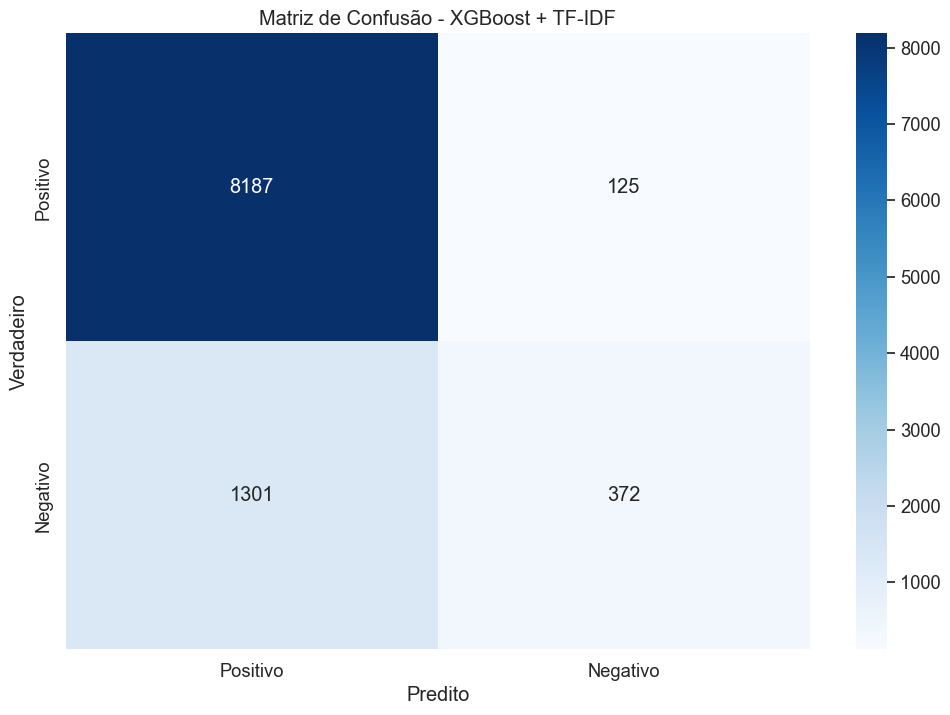


Relatório de Classificação (XGBoost + TF-IDF):

=== Relatório de Desempenho: XGBoost + TF-IDF ===
Accuracy : 0.8572
Precisão : 0.8629
Recall   : 0.9850
F1-score : 0.9199

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.75      0.22      0.34      1673
         pos       0.86      0.98      0.92      8312

    accuracy                           0.86      9985
   macro avg       0.81      0.60      0.63      9985
weighted avg       0.84      0.86      0.82      9985



In [25]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Codificar as classes se estiverem como texto
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Treinar o modelo de XGBoost com TF-IDF
xgb_tfidf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',          # Adequado para classificação binária
    objective='binary:logistic',    # Objetivo específico para binário
    max_depth=8,                    # Profundidade das árvores
    learning_rate=0.1,              # Taxa de aprendizagem (podes testar 0.05, 0.01)
    n_estimators=300,               # Número de árvores (mais árvores, mais capacidade)
    subsample=0.8,                  # Fracção de dados usada por árvore
    colsample_bytree=0.8,           # Fracção de features por árvore
    reg_alpha=0.1,                  # Regularização L1
    reg_lambda=1.0,                 # Regularização L2
    scale_pos_weight=1,            # Podes ajustar para classes desbalanceadas
    random_state=42,
    n_jobs=-1                       # Acelerar com todos os cores
)
xgb_tfidf.fit(X_train_tfidf, y_train_enc)

# Prever e avaliar
y_pred_xgb_tfidf = xgb_tfidf.predict(X_test_tfidf)

# Avaliar o modelo com matriz de confusão e relatório de classificação
print("Matriz de Confusão (XGBoost + TF-IDF):")
plot_confusion_matrix(y_test_enc, y_pred_xgb_tfidf, model_name="XGBoost + TF-IDF", labels=[1, 0])

print("\nRelatório de Classificação (XGBoost + TF-IDF):")
print_classification_report(y_test_enc, y_pred_xgb_tfidf, model_name="XGBoost + TF-IDF", pos_label=1)


In [ ]:
# Frase de exemplo
nova_frase = "I hate this product. It's the worst I've ever used."

# 1. Aplicar a mesma função de limpeza usada no treino
frase_limpa = clean_text_ultimate(nova_frase, **best_params)

# 2. Vetorizar com o mesmo TF-IDF treinado (atenção: .transform, não .fit_transform!)
frase_vetorizada = tfidf.transform([frase_limpa])  # Coloca-se dentro de lista!

# 3. Prever a classe
predicao = xgb_tfidf.predict(frase_vetorizada)

# 4. Mostrar o resultado
print("Frase:", nova_frase)
print("Frase limpa:", frase_limpa)
print("Previsão:", predicao[0])

Frase: I hate this product. It's the worst I've ever used.
Frase limpa: hate product worst ever used
Predição: 0


## 6. ``Rede Neuronal``
- **Nota:** O modelo das redes neuronais é um modelo pesado, cuidado ao executar o código!

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [30]:
dropout = 0.3 # Taxa de dropout
num_epochs = 20 # Número de épocas
lr=0.001 # Learning rate
batch_size=64 # Tamanho do batch
hidden_dim = 128 # Dimensão do hidden layer
num_layers=2 # Número de layers

# Callbacks - early_stopper
patience=5 # Número de épocas sem melhoria antes de parar o treinamento
min_delta=0.001 # Mudança mínima para considerar uma melhoria

CallBacks

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [32]:
weights_dir = Path(base_dir) / "models_weights"

class SaveBestModel:
    def __init__(self, save_path="melhor_modelo.pt"):
        self.best_loss = float('inf')
        self.save_path = weights_dir / save_path

        # Verificar se a pasta existe, senão criar
        if not self.save_path.parent.exists():
            self.save_path.parent.mkdir(parents=True, exist_ok=True)

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.save_path)
            print(f"💾 Melhor modelo salvo em: {self.save_path}")

Functions

In [33]:
def evaluate_metrics(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, pos_label=1)
    rec = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)

    return acc, prec, rec, f1

In [34]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, 
                early_stopping=None, save_best_model=None):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    print(f"\n📚 Início do treino do modelo: {model.__class__.__name__}\n{'='*60}")
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs}", leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})

        avg_train_loss = total_loss / len(train_loader)
        val_loss, val_acc = validate_model(model, val_loader, criterion)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"✅ Época {epoch+1:02d}: Train Loss = {avg_train_loss:.4f} | Val Loss = {val_loss:.4f} | Val Acc = {val_acc:.4f}")

        if save_best_model:
            save_best_model(model, val_loss)

        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("⏹️ Early stopping ativado!")
                break

    print(f"\n🏁 Treino finalizado para {model.__class__.__name__}")
    return model, history


In [35]:
def evaluate_model(model, test_loader, model_name="Modelo", label_names=["pos", "neg"]):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)  # [batch, seq_len=1, features]
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Converte os índices de volta para os rótulos reais (ex: 0 -> "neg", 1 -> "pos")
    all_preds_labels = le.inverse_transform(all_preds)
    all_true_labels = le.inverse_transform(all_labels)

    # Visualização e relatório
    plot_confusion_matrix(all_true_labels, all_preds_labels, model_name=model_name, labels=label_names)
    print_classification_report(all_true_labels, all_preds_labels, model_name=model_name, pos_label=label_names[0])

In [36]:
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [37]:
def plot_training_history(history, model_name="Modelo"):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label="Train Loss", marker='o')
    plt.plot(history['val_loss'], label="Val Loss", marker='o')
    plt.title(f"Loss - {model_name}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label="Val Accuracy", color='green', marker='o')
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.ylim(0.8, 1)  # Define o intervalo da accuracy entre 0 e 1
    plt.legend()

    plt.tight_layout()
    plt.show()

TF-IDF

In [38]:
from torch.utils.data import random_split, DataLoader, TensorDataset

# Codificação das classes
le = LabelEncoder()
y_train_enc = le.fit_transform(df_train['class'])
y_test_enc = le.transform(df_test['class'])

# Conversão para tensores
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

# Criação do TensorDataset para o treino e teste
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Definir a proporção de validação (ex: 80% treino, 20% validação)
val_size = int(0.2 * len(train_dataset))  # 20% para validação
train_size = len(train_dataset) - val_size  # O resto vai para o treino

# Dividir o dataset de treino em treino e validação
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoader para treino
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader para validação
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# DataLoader para teste (já estava definido)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 6.1. `GRU` para Classificação de Texto

In [39]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=dropout):
        super(GRUClassifier, self).__init__()

        # Camada GRU
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Camada de Normalização
        self.bn = nn.BatchNorm1d(hidden_dim)
        
        # Camada Dropout
        self.dropout = nn.Dropout(dropout)

        # Camada totalmente conectada (FC) para saída
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Inicialização dos pesos
        self._init_weights()

    def _init_weights(self):
        # Inicialização Xavier para pesos da camada FC
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)

    def forward(self, x):
        # Verificar o formato de entrada
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Se for 2D, fazemos unsqueeze para adicionar seq_len=1

        # Passar pelo GRU
        _, hn = self.gru(x)

        # Processar o hidden state da última camada
        hidden_last = hn[-1]
        hidden_last = self.bn(hidden_last)
        hidden_last = self.dropout(hidden_last)
        output = self.fc(hidden_last)
        return output

#### 6.3.1. `TF-IDF`

In [40]:
# Definir parâmetros
input_dim_tfidf = X_train_tfidf.shape[1]

output_dim = len(np.unique(y_train_enc))  # Número de classes

# Instanciar o modelo GRU
gru_model_tfidf = GRUClassifier(input_dim=input_dim_tfidf,
                                hidden_dim=hidden_dim,
                                output_dim=output_dim)

# Callbacks
early_stopper_gru_tfidf = EarlyStopping(patience=patience, min_delta=min_delta)
save_best_gru_tfidf = SaveBestModel("melhor_modelo_gru_tfidf.pt")

# Treinamento
gru_model_tfidf, history_gru_tfidf = train_model(
    gru_model_tfidf,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    lr=lr,
    early_stopping=early_stopper_gru_tfidf,
    save_best_model=save_best_gru_tfidf
)


📚 Início do treino do modelo: GRUClassifier


✅ Época 01: Train Loss = 0.4841 | Val Loss = 0.3494 | Val Acc = 0.8574
💾 Melhor modelo salvo em: C:\Users\diogo\Desktop\Filologia_Digital-Modulo_V\Session4\models_weights\melhor_modelo_gru_tfidf.pt


✅ Época 02: Train Loss = 0.3450 | Val Loss = 0.3522 | Val Acc = 0.8594


✅ Época 03: Train Loss = 0.3179 | Val Loss = 0.3552 | Val Acc = 0.8566


✅ Época 04: Train Loss = 0.3049 | Val Loss = 0.3608 | Val Acc = 0.8530


✅ Época 05: Train Loss = 0.2925 | Val Loss = 0.3671 | Val Acc = 0.8521


✅ Época 06: Train Loss = 0.2899 | Val Loss = 0.3651 | Val Acc = 0.8533
⏹️ Early stopping ativado!

🏁 Treino finalizado para GRUClassifier


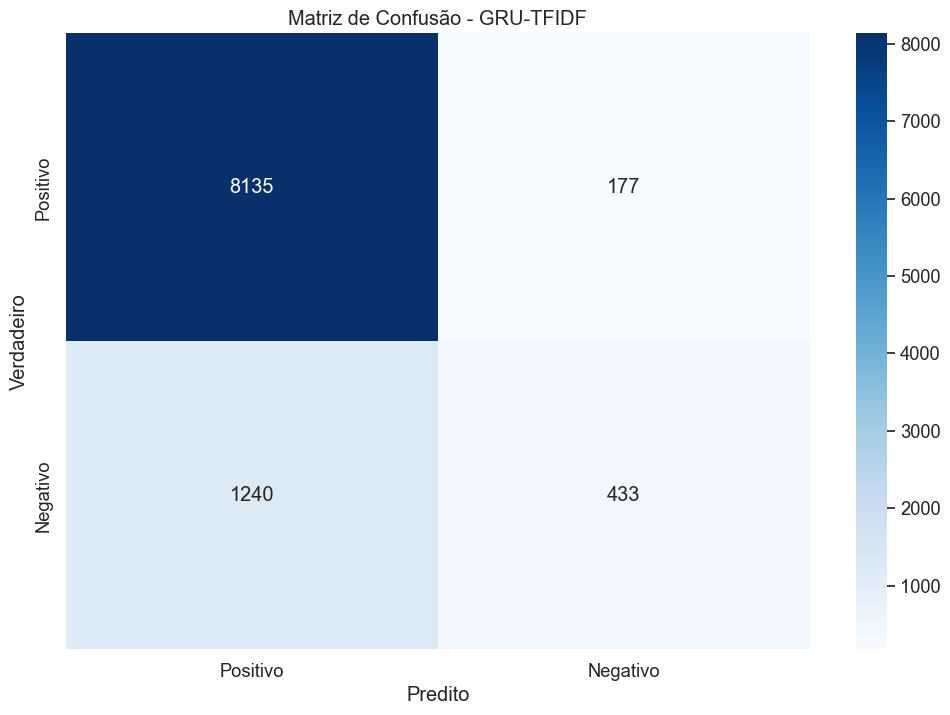


=== Relatório de Desempenho: GRU-TFIDF ===
Accuracy : 0.8581
Precisão : 0.8677
Recall   : 0.9787
F1-score : 0.9199

--- Relatório Detalhado ---
              precision    recall  f1-score   support

         neg       0.71      0.26      0.38      1673
         pos       0.87      0.98      0.92      8312

    accuracy                           0.86      9985
   macro avg       0.79      0.62      0.65      9985
weighted avg       0.84      0.86      0.83      9985



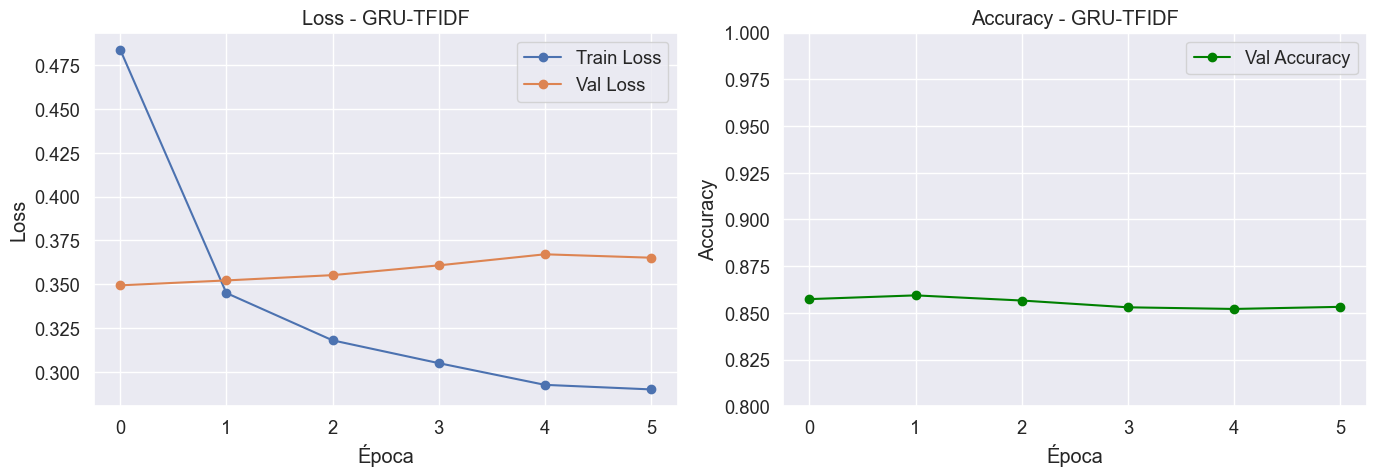

In [41]:
# Carregar o melhor modelo e avaliar
gru_model_tfidf.load_state_dict(torch.load(weights_dir / "melhor_modelo_gru_tfidf.pt"))
evaluate_model(gru_model_tfidf, test_loader, model_name="GRU-TFIDF")

# Visualizar resultados
plot_training_history(history_gru_tfidf, model_name="GRU-TFIDF")